In [2]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import category_encoders as ce

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.utils.data import DataLoader

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

# Utility
import os
import time
import datetime
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from bayes_opt import BayesianOptimization
from num2words import num2words
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

In [3]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
international_trade = pd.read_csv('../data/international_trade.csv')
train.drop(columns = 'ID', inplace = True)
test.drop(columns = 'ID', inplace = True)

In [5]:
train = train.rename(columns={'supply(kg)':'supply','price(원/kg)':'price'})
train.columns

Index(['timestamp', 'item', 'corporation', 'location', 'supply', 'price'], dtype='object')

In [6]:
# 시계열 데이터 처리
train.timestamp = pd.to_datetime(train.timestamp)
test.timestamp = pd.to_datetime(test.timestamp)

########### test 데이터 supply 컬럼 추가
# test['supply'] = np.zeros((len(test),1))
# def find_lastyear_supply(row):
#     # date1 : 1년 전 같은 datetime
#     date1 = pd.to_datetime(f'{row["timestamp"].year-1}-{row["timestamp"].month}-{row["timestamp"].day}').date()
#     # date2 : 2년 전 같은 datetime
#     date2 = pd.to_datetime(f'{row["timestamp"].year-2}-{row["timestamp"].month}-{row["timestamp"].day}').date()
# #     print(date)
#     # 1,2년 전 같은 날짜 & 유통업체 & 지역 & 품목의 supply 평균값으로 test에 supply컬럼 추가
#     row['supply'] = train[((train['timestamp'].dt.date==date1)|(train['timestamp'].dt.date==date2))&
#                             (train['corporation']==row['corporation'])&
#                             (train['location']==row['location']) &
#                             (train['item']==row['item'])]['supply'].sum()
# #     print(row['supply'])
#     return row
# test = test.apply(find_lastyear_supply,axis=1)
########### test 데이터 supply 컬럼 추가 -END-

# year
train['year'] = train.timestamp.dt.year
test['year'] = test.timestamp.dt.year

# month
train['month'] = train.timestamp.dt.month
test['month'] = test.timestamp.dt.month

# day
train['day'] = train.timestamp.dt.day
test['day'] = test.timestamp.dt.day

# week
train['week'] = train.timestamp.dt.dayofweek
test['week'] = test.timestamp.dt.dayofweek

# 주말여부
train['weekend'] = train.week.apply(lambda x : 1 if x in [1,2] else 0)
test['weekend'] = test.week.apply(lambda x : 1 if x in [1,2] else 0)

# date (월-일)
# train['date'] = train.timestamp.apply(lambda x : int(str(x)[5:7] + str(x)[8:10]))
# test['date'] = test.timestamp.apply(lambda x : int(str(x)[5:7] + str(x)[8:10]))

# year_month
train['year_month'] = train.timestamp.apply(lambda x : str(x)[0:7])
test['year_month'] = test.timestamp.apply(lambda x : str(x)[0:7])

In [7]:
# test에 supply 잘 들어갔는지 확인
# print(test[(test['timestamp']=='2023-03-27')&(test['item']=='RD')&(test['corporation']=='F')&(test['location']=='J')]['supply'])
# print(train[(train['timestamp']=='2021-03-27')&(train['item']=='RD')&(train['corporation']=='F')&(train['location']=='J')]['supply'])
# print(train[(train['timestamp']=='2022-03-27')&(train['item']=='RD')&(train['corporation']=='F')&(train['location']=='J')]['supply'])

In [8]:
# 나중에 international data 사용할 때 year-month 사용해서 컬럼 추가
train



,timestamp,item,corporation,location,supply,price,year,month,day,week,weekend,year_month
0,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1,1,2019-01
1,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,2,1,2019-01
2,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,3,0,2019-01
3,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,4,0,2019-01
4,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,5,0,2019-01
...,...,...,...,...,...,...,...,...,...,...,...,...
59392,2023-02-27,RD,F,J,452440.0,468.0,2023,2,27,0,0,2023-02
59393,2023-02-28,RD,F,J,421980.0,531.0,2023,2,28,1,1,2023-02
59394,2023-03-01,RD,F,J,382980.0,574.0,2023,3,1,2,1,2023-03
59395,2023-03-02,RD,F,J,477220.0,523.0,2023,3,2,3,0,2023-03


In [9]:
# 감귤과 나머지로 데이터프레임 구분
tg_train_index = train[train['item']=='TG'].index
train_TG = train.iloc[tg_train_index,:]
train_rest = train.drop(index=tg_train_index,axis=0)

tg_test_index = test[test['item']=='TG'].index
test_TG = test.iloc[tg_test_index,:]
test_rest = test.drop(index=tg_test_index,axis=0)

## 후에 사용할 test 데이터셋의 인덱스를 미리 저장
org_test_TG_index = test_TG.index
org_test_rest_index = test_rest.index

In [10]:
# Encoding 
encoders_TG = {}
for col in ['item','corporation','location','year','month','day','week']:
    encoder = ce.TargetEncoder()
    train_TG[col] = encoder.fit_transform(train_TG[col].astype(str),train_TG['price'])
    test_TG[col] = encoder.transform(test_TG[col].astype(str))
    encoders_TG[col] = encoder
# encoder = LabelEncoder()
# train_TG['location'] = encoder.fit_transform(train_TG['location'])
# test_TG['location'] = encoder.transform(test_TG['location'])
# encoders_TG['location'] = encoder

encoders_rest = {}
for col in ['item','corporation','location','year','month','day','week']:
    encoder = ce.TargetEncoder()
    train_rest[col] = encoder.fit_transform(train_rest[col].astype(str),train_rest['price'])
    test_rest[col] = encoder.transform(test_rest[col].astype(str))
    encoders_rest[col] = encoder
# encoder = LabelEncoder()
# train_rest['location'] = encoder.fit_transform(train_rest['location'])
# test_rest['location'] = encoder.transform(test_rest['location'])
# encoders_rest['location'] = encoder

###

In [11]:
# Scaling
# price scaling
TG_mms = MinMaxScaler()
## 감귤만 일단 조정
train_TG['price'] = TG_mms.fit_transform(np.reshape(train_TG['price'].values,(-1,1)))


In [12]:
# drop unnecessary cols, define features and target
train_TG_ = train_TG.drop(columns = ['timestamp', 'year_month'])
train_rest_ = train_rest.drop(columns = ['timestamp', 'year_month'])
test_TG_ = test_TG.drop(columns = ['timestamp', 'year_month'])
test_rest_ = test_rest.drop(columns = ['timestamp', 'year_month'])

feature_TG = train_TG_.drop(columns=['supply','price']) # 피처에 supply 미포함
feature_te_TG = test_TG_ #.drop(columns=['supply'])  피처에 supply 미포함
feature_rest = train_rest_.drop(columns=['supply','price']) 
feature_te_rest = test_rest_ #.drop(columns=['supply']) 
# feature = train_.drop(columns=['price']) # 피처에 supply 포함하는 버전
# feature_te = test_
target_TG = train_TG_.price
target_rest = train_rest_.price

여기서부터 lgbm전까지는 feature_TG, target_TG로 LSTM모델을 사용하여 학습 및 예측
<br/>
참고 : https://github.com/jungsungmoon/nongsan#eda

In [13]:
print(torch.cuda.is_available())
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(torch.cuda.get_device_name())
print(torch.cuda.device_count())

True
NVIDIA GeForce RTX 3050 Ti Laptop GPU
1


### LSTF과제에 대한 3가지 모델 : https://today-1.tistory.com/60

#### Linear

In [14]:
class LTSF_Linear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, individual, feature_size):
        super(LTSF_Linear, self).__init__()
        
        # 입력 파라미터를 멤버 변수로 저장
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.individual = individual
        self.channels = feature_size

        # individual이 True인 경우, 각 채널에 대해 별도의 선형 레이어를 생성
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forcast_size))
        # individual이 False인 경우, 하나의 선형 레이어만 생성
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forcast_size)

    def forward(self, x):
        # forward 메서드: 입력 데이터를 받아 예측값을 반환
        if self.individual:
            # individual이 True인 경우, 각 채널에 대해 별도의 선형 레이어를 통과시킨 후 결과를 합침
            output = torch.zeros([x.size(0), self.forcast_size, x.size(2)], dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:, :, i] = self.Linear[i](x[:, :, i])
            x = output
        else:
            # individual이 False인 경우, 전체 데이터에 대해 하나의 선형 레이어를 통과시킴
            x = self.Linear(x.permute(0, 2, 1)).permute(0, 2, 1)
        return x


In [57]:
# window_size = 365 (이전 1년을 입력받아)
# forcast_size = 28 (28일의 price를 예측)
# feature_size = 9개
ltsf_linear = LTSF_Linear(365, 28, False, len(feature_TG.columns))
criterion_ltsf_linear = nn.MSELoss()
optim_ltsf_linear = optim.Adam(ltsf_linear.parameters(),lr=0.0002)

In [58]:
# prepare dataset for linear

# Scaling the target encoded data
# ['item','corporation','location','year','month','day','week']
mms_columns = ['item','corporation','location','year','month','day','week']
mms_features = MinMaxScaler()
features_TG_scaled = feature_TG.copy()
features_TG_scaled[mms_columns] = mms_features.fit_transform(features_TG_scaled[mms_columns])
features_TG_scaled

,item,corporation,location,year,month,day,week,weekend
0,0.0,0.405446,0.0,0.654886,0.077494,0.195701,1.000000,1
1,0.0,0.405446,0.0,0.654886,0.077494,0.129368,0.983033,1
2,0.0,0.405446,0.0,0.654886,0.077494,0.000000,0.983563,0
3,0.0,0.405446,0.0,0.654886,0.077494,0.796712,0.988603,0
4,0.0,0.405446,0.0,0.654886,0.077494,0.580131,0.892926,0
...,...,...,...,...,...,...,...,...
15225,0.0,0.000000,1.0,0.000000,0.184014,0.972893,0.989903,0
15226,0.0,0.000000,1.0,0.000000,0.184014,0.963286,1.000000,1
15227,0.0,0.000000,1.0,0.000000,0.489610,0.195701,0.983033,1
15228,0.0,0.000000,1.0,0.000000,0.489610,0.129368,0.983563,0


In [64]:
# to tensor
features_TG_scaled_tensor = torch.tensor(features_TG_scaled.values).unsqueeze(1)
target_TG_tensor = torch.tensor(target_TG)

features_TG_scaled_tensor.size(), target_TG_tensor.size()

(torch.Size([15230, 1, 8]), torch.Size([15230]))

item
0.0    15230
Name: count, dtype: int64

### Basic LSTM forecasting TG

In [13]:
# define LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers,output_dim):
        '''
        input_dim = 피처의 개수
        hidden_dim = hidden_state의 컬럼 개수 (아무값이나)
        num_layers = lstm net의 개수 (보통 1로 지정)
        output_dim = 가격만 예측하니까 1로 지정
        '''
        super(LSTM,self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim 
        self.output_dim = output_dim 
        self.num_layers = num_layers 
        
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                           batch_first=True)
        self.fc0 = nn.Linear(hidden_dim,64)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, output_dim)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # lstm 셀 및 가중치 초기화
        h_0 = Variable(torch.randn(self.num_layers,x.size(0),self.hidden_dim))
        c_0 = Variable(torch.randn(self.num_layers,x.size(0),self.hidden_dim))
        
        out,(hn,cn) = self.lstm(x, (h_0,c_0))
        hn = hn.view(-1,self.hidden_dim) # size = (x.size(0),hidden_dim)
        out = self.fc0(hn)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out
    
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [57]:
feature_TG.columns

Index(['item', 'corporation', 'location', 'year', 'month', 'day', 'week',
       'weekend', 'date'],
      dtype='object')

In [14]:
# Model instance , criterion, optimizer
batch_size = 365

input_dim = len(feature_TG.columns) # 피처 개수
hidden_dim = 128 # 
output_dim = 1
num_layers = 1

model = LSTM(input_dim, hidden_dim, num_layers, output_dim)

criterion = RMSELoss() # RMSE
optimizer = optim.Adam(model.parameters(), lr=0.0002)

In [15]:
feature_TG.shape

(15230, 9)

In [16]:
# pandas data >> tensor data
X_train = feature_TG
y_train = target_TG

# X_train = feature_TG[:-1500]
# X_val   = feature_TG[-1500:]
# y_train = target_TG[:-1500]
# y_val   = target_TG[-1500:]

X_train_tensors = Variable(torch.Tensor(X_train.values)).unsqueeze(1)
# X_val_tensors = Variable(torch.Tensor(X_val.values)).unsqueeze(1)
y_train_tensors = Variable(torch.Tensor(y_train.values)).unsqueeze(1)
# y_val_tensors = Variable(torch.Tensor(y_val.values)).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensors, y_train_tensors)
# val_dataset = TensorDataset(X_val_tensors, y_val_tensors)
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)

In [17]:
# Train the model
best_loss = float('inf')
early_stopping_counter = 0
train_losses = []
val_losses = []
epoch_counter = 0 # epoch 횟수 카운팅용
epochs = 500 # 훈련 횟수
patience = 50 # early_stopping 기준

for epoch in range(epochs):
    model.train() # 모델을 '학습 모드'로 설정
    train_loss = 0
    
    for batch_x, batch_y in train_loader: # 미니 배치 학습
        optimizer.zero_grad() # optimizer의 가중치를 초기화
        output = model(batch_x) # 순전파 진행
#         print('밖에서 본 output : ',output.size())
        loss = criterion(output, batch_y) # 평가(손실 계산)
        train_loss += loss.item() * batch_x.size(0) # 손실 누적
        loss.backward() # 역전파 진행
        optimizer.step() # 모델의 가중치 업데이트

    average_train_loss = train_loss / len(train_loader.dataset)	# 평균 손실값
    train_losses.append(average_train_loss)
    
    if (epoch>0) & (epoch % 20 == 0) :
        print(f'epoch : {epoch} , train_loss : {average_train_loss}')
        
    # Early Stopping
    if average_train_loss < best_loss: 
        best_loss = average_train_loss 
        torch.save(model.state_dict(), '../models/lstm_tg_model.pth') #모델 저장
        early_stopping_counter = 0 # 카운팅 초기화
    else: 
        early_stopping_counter += 1 
        if early_stopping_counter >= patience: 
            break # 학습 종료
    
#     model.eval() # 모델을 '평가 모드'로 설정
    
#     with torch.no_grad(): # 그래디언트 계산 비활성화
#         val_loss = 0
        
#         for batch_x,batch_y in val_loader: 
#             batch_x = batch_x
#             batch_y = batch_y
#             output = model(batch_x) # 예측을 생성
#             loss = criterion(output.unsqueeze(1), batch_y) # 손실 계산
#             val_loss += loss.item() * batch_x.size(0) # 검증 손실 누적
        
#         average_val_loss = val_loss / len(val_loader.dataset) # 평균 검증 손실 계산
#         val_losses.append(average_val_loss)
        
#         epoch_counter+=1
#         if epoch_counter%20 == 0:
#             print('Epoch: {}, train_loss: {:.4f}, val_loss: {:.4f}'.format(
#                 epoch_counter, average_train_loss, average_val_loss))
        


epoch : 20 , train_loss : 0.12137973876040152
epoch : 40 , train_loss : 0.11896002286028799
epoch : 60 , train_loss : 0.11594119259276753
epoch : 80 , train_loss : 0.11849993876794883
epoch : 100 , train_loss : 0.11457680167724486
epoch : 120 , train_loss : 0.1142556601260848
epoch : 140 , train_loss : 0.11429510883942921
epoch : 160 , train_loss : 0.11440431531359706
epoch : 180 , train_loss : 0.11476243123196882
epoch : 200 , train_loss : 0.11453162918866502


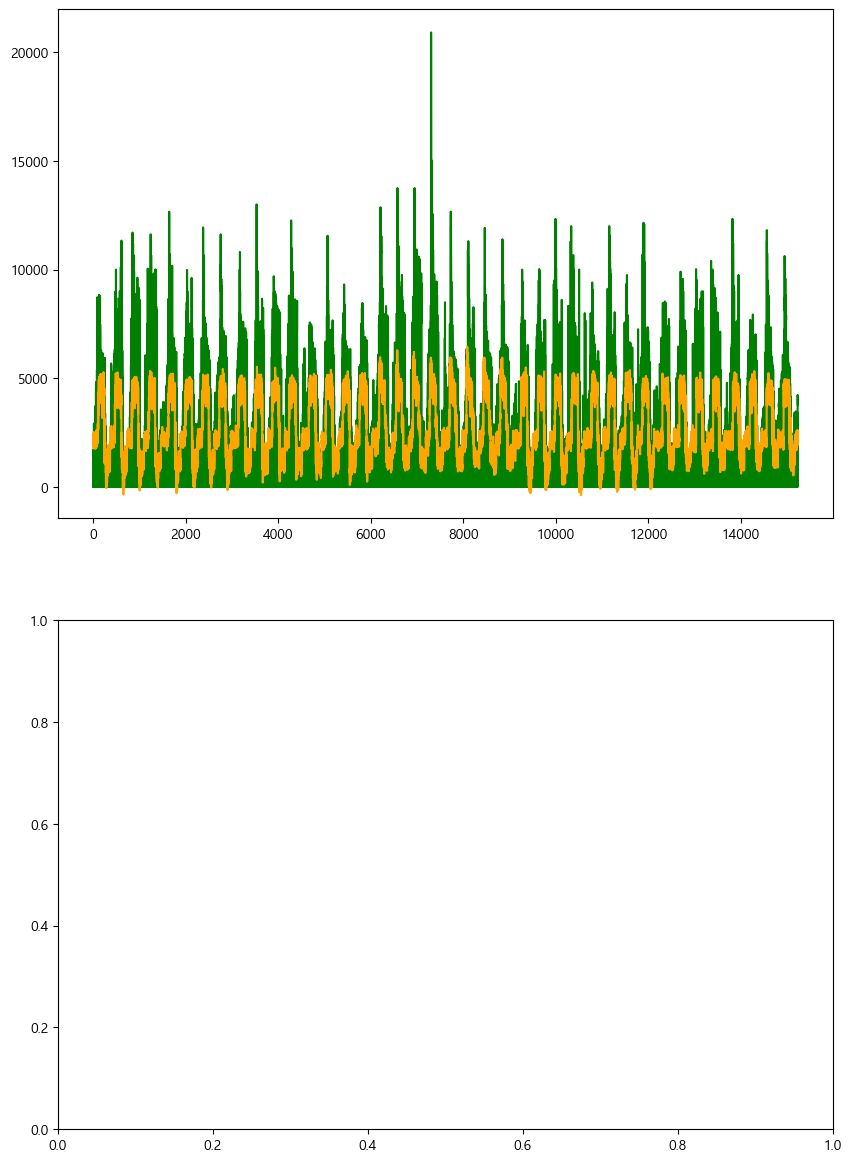

In [18]:
# 시각화
fig,axs = plt.subplots(2,1,figsize=(10,8))
plt.subplots_adjust(top=1.5,bottom=0.1)
# 기존 감귤
length = range(len(X_train))
axs[0].plot(length, TG_mms.inverse_transform(np.reshape(y_train,(-1,1))),color='green')
predict = model(X_train_tensors).detach().numpy()
axs[0].plot(length, TG_mms.inverse_transform(predict),color='orange')


plt.show()

In [95]:
# test_TG 예측
feature_te_TG_tensors = Variable(torch.Tensor(feature_te_TG.values)).unsqueeze(1)

pred_test_TG = model(feature_te_TG_tensors).detach()

pred_test_TG_inverse = TG_mms.inverse_transform(pred_test_TG)
pred_test_TG_inverse

array([[1400.50531786],
       [1601.11594079],
       [2721.11422148],
       [2838.79328682],
       [2101.71285598],
       [1520.1619077 ],
       [1720.72081028],
       [1549.6233463 ],
       [2011.80481501],
       [2919.18789889],
       [2956.0274325 ],
       [2357.52841065],
       [1732.76386285],
       [1503.29717867],
       [1523.48914642],
       [1552.00139195],
       [2869.07742172],
       [3090.78137973],
       [2583.44150168],
       [1918.7371591 ],
       [1404.86867723],
       [1647.12259505],
       [1842.40399664],
       [3029.49182911],
       [3113.81157963],
       [2918.68222341],
       [2228.60219418],
       [1591.77745754],
       [1336.78942849],
       [1626.70941375],
       [2942.54649186],
       [3064.45478638],
       [2671.29319134],
       [1862.13390848],
       [1306.75361358],
       [1391.58495937],
       [1473.37243789],
       [3220.55833367],
       [3021.9827196 ],
       [2943.58650711],
       [1471.23087263],
       [1579.268

아래부터는 feature_rest, target_rest로 학습 및 예측

In [96]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import lightgbm as lgb

def get_MSE(feature,target):
    # MSE를 스코어링 함수로 정의
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

    # LightGBM 모델 초기화
    model = lgb.LGBMRegressor(verbose = -1,force_col_wise = True)
    # force_col_wise = 메모리 이슈로 도중에 row-wise 탐색으로 바뀌는 것을 방지

    # 교차 검증 수행
    cross_val_scores = -cross_val_score(model, feature, target, cv=5, scoring=mse_scorer)
    rmse = np.sqrt(cross_val_scores)

    # 교차 검증 스코어 출력
    print("MAE scores for each fold:", rmse)  # Negative values are used because cross_val_score returns negated scores
    print("Mean MAE:", rmse.mean())

In [97]:
get_MSE(feature_rest,target_rest)

MAE scores for each fold: [ 463.0224741   370.18996645  343.47780897 1053.67303197  942.78706218]
Mean MAE: 634.6300687330363


In [98]:
def lbgm_feature_importance(feature,target):
    # LightGBM 모델 초기화
    model = lgb.LGBMRegressor(verbose = 0,force_col_wise=True)

    # 모델을 학습 , 중요도 계산
    model.fit(feature, target)

    # 피쳐 중요도 가져오기
    feature_importance = model.feature_importances_

    # 중요도가 높은 상위 20개 피쳐 인덱스 가져오기
    top_20_feature_indices = feature_importance.argsort()[-25:][::-1]

    # 상위 20개 피쳐의 중요도 가져오기
    top_20_feature_importance = feature_importance[top_20_feature_indices]

    # 상위 20개 피쳐의 이름 가져오기
    top_20_feature_names = feature.columns[top_20_feature_indices]

    # 중요도 시각화
    plt.figure(figsize=(10, 6))
    plt.barh(top_20_feature_names, top_20_feature_importance)
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importance')
    plt.show()
    
    return top_20_feature_importance,top_20_feature_names

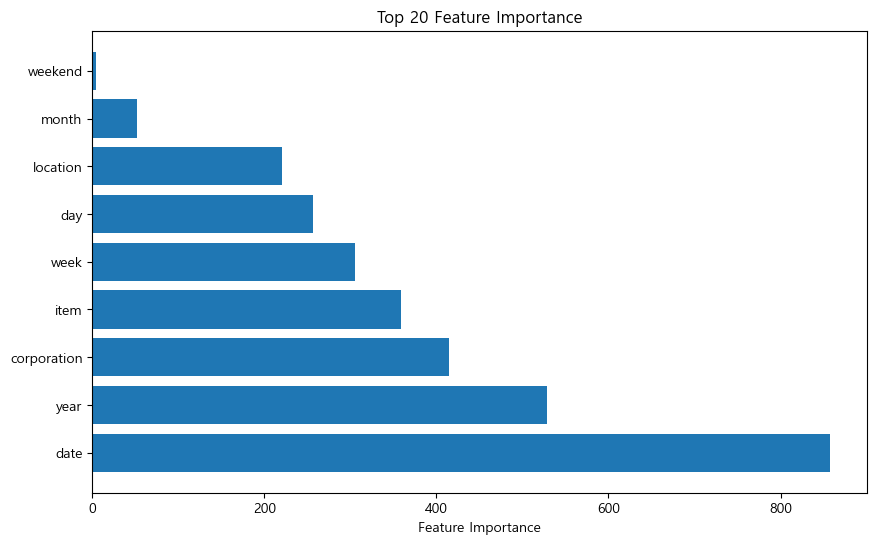

In [99]:
top_20_feature_importance,top_20_feature_names = lbgm_feature_importance(feature_rest,target_rest)

In [100]:
top_20_feature_importance, top_20_feature_names

(array([858, 529, 415, 359, 305, 257, 221,  52,   4]),
 Index(['date', 'year', 'corporation', 'item', 'week', 'day', 'location',
        'month', 'weekend'],
       dtype='object'))

In [101]:
# 피처 선택
# 2가지 버전 준비 
# 1. 피처 선택 버전
threshold = 150
low_importance_features_name = list(top_20_feature_names[np.where(top_20_feature_importance<150)[0]])
feature_rest_selected = feature_rest.drop(columns=low_importance_features_name)
feature_te_rest_selected = feature_te_rest.drop(columns=low_importance_features_name)
# 2. 모든 피처로 학습 >> feature, feature_te 그대로 사용

In [102]:
# 1. 피처 선택 버전 
# MSE 확인
get_MSE(feature_rest_selected,target_rest)
# 모델 학습 (아직 튜닝 미완료)
v1_lgbm_model = lgb.LGBMRegressor(force_col_wise=True)
v1_lgbm_model.fit(feature_rest_selected,target_rest)
v1_pred = v1_lgbm_model.predict(feature_te_rest_selected)

MAE scores for each fold: [ 451.34364393  370.55940005  348.68843382 1050.39407015  937.47196615]
Mean MAE: 631.6915028198136


In [137]:
# 2. 피처 선택 버전 
# MSE 확인
get_MSE(feature_rest,target_rest)
# 모델 학습 (아직 튜닝 미완료)
v2_lgbm_model = lgb.LGBMRegressor(force_col_wise=True)
v2_lgbm_model.fit(feature_rest,target_rest)
v2_pred = v2_lgbm_model.predict(feature_te_rest)

MAE scores for each fold: [ 463.0224741   370.18996645  343.47780897 1053.67303197  942.78706218]
Mean MAE: 634.6300687330363


In [138]:
final_pred = np.concatenate([pred_test_TG_inverse.reshape(-1),
              v2_pred])

In [140]:
# TG 랑 rest 예측값 합치기
# origin_index
# -  org_test_TG_index
# -  org_test_rest_index
sample_submission = pd.read_csv('../data/sample_submission.csv')
sample_submission['answer'] = final_pred

sample_submission

,ID,answer
0,TG_A_J_20230304,1400.505318
1,TG_A_J_20230305,1601.115941
2,TG_A_J_20230306,2721.114221
3,TG_A_J_20230307,2838.793287
4,TG_A_J_20230308,2101.712856
...,...,...
1087,RD_F_J_20230327,536.137093
1088,RD_F_J_20230328,498.531722
1089,RD_F_J_20230329,498.531722
1090,RD_F_J_20230330,498.531722


In [143]:
# sample_submission으로 저장하기
# sample_submission.set_index('ID',inplace=True)
sample_submission.to_csv('../data/song9_sumbit_231112.csv')